# Part 1. Install Packages

In [60]:
## install required packages
#!pip install swig
#!pip install wrds
#!pip install pyportfolioopt
## install finrl library
## !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git


In [61]:
import pandas as pd
import numpy as np
import datetime
import gymnasium
import stable_baselines3
import stockstats
import alpaca_trade_api
import exchange_calendars

import yfinance as yf

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl import config_tickers
from finrl.config import INDICATORS, TRAINED_MODEL_DIR, RESULTS_DIR


import itertools

# Part 2. Fetch data

**OHLCV**: Data downloaded are in the form of OHLCV, corresponding to **open, high, low, close, volume,** respectively. OHLCV is important because they contain most of numerical information of a stock in time series. From OHLCV, traders can get further judgement and prediction like the momentum, people's interest, market trends, etc.

In [62]:
TRAIN_START_DATE = '2021-01-01'
TRAIN_END_DATE = '2023-07-01'
TRADE_START_DATE = '2023-07-01'
TRADE_END_DATE = '2024-09-15'

config_tickers.DOW_30_TICKER


['AXP',
 'AMGN',
 'AAPL',
 'BA',
 'CAT',
 'CSCO',
 'CVX',
 'GS',
 'HD',
 'HON',
 'IBM',
 'INTC',
 'JNJ',
 'KO',
 'JPM',
 'MCD',
 'MMM',
 'MRK',
 'MSFT',
 'NKE',
 'PG',
 'TRV',
 'UNH',
 'CRM',
 'VZ',
 'V',
 'WBA',
 'WMT',
 'DIS',
 'DOW']

In [63]:
#aapl_df_yf = yf.download(tickers = "aapl", start=TRAIN_START_DATE, end=TRADE_END_DATE)
#aapl_df_yf.head()

df_raw = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = config_tickers.DOW_30_TICKER).fetch_data()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (27900, 8)


In [64]:
df_raw.head()

,date,open,high,low,close,volume,tic,day
0,2021-01-04,133.520004,133.610001,126.760002,126.683434,143301900,AAPL,0
1,2021-01-04,231.250000,231.250000,223.669998,201.544556,3088200,AMGN,0
2,2021-01-04,121.300003,121.800003,116.849998,112.457108,3472100,AXP,0
3,2021-01-04,210.000000,210.199997,202.490005,202.720001,21225600,BA,0
4,2021-01-04,183.000000,185.979996,180.250000,168.735245,4078300,CAT,0


# Part 3: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

In [65]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_vix=True,
                     use_turbulence=True,
                     user_defined_feature = False)


In [66]:
processed = fe.preprocess_data(df_raw)

[*********************100%***********************]  1 of 1 completed

Successfully added technical indicators
Shape of DataFrame:  (929, 8)
Successfully added vix


Successfully added turbulence index


In [67]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)
processed_full.head()


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2021-01-04,AAPL,133.520004,133.610001,126.760002,126.683434,143301900.0,0.0,0.0,129.68168,125.251494,100.0,66.666667,100.0,126.683434,126.683434,26.969999,0.0
1,2021-01-04,AMGN,231.250000,231.250000,223.669998,201.544556,3088200.0,0.0,0.0,129.68168,125.251494,100.0,66.666667,100.0,201.544556,201.544556,26.969999,0.0
2,2021-01-04,AXP,121.300003,121.800003,116.849998,112.457108,3472100.0,0.0,0.0,129.68168,125.251494,100.0,66.666667,100.0,112.457108,112.457108,26.969999,0.0
3,2021-01-04,BA,210.000000,210.199997,202.490005,202.720001,21225600.0,0.0,0.0,129.68168,125.251494,100.0,66.666667,100.0,202.720001,202.720001,26.969999,0.0
4,2021-01-04,CAT,183.000000,185.979996,180.250000,168.735245,4078300.0,0.0,0.0,129.68168,125.251494,100.0,66.666667,100.0,168.735245,168.735245,26.969999,0.0


In [68]:
# Part 4: Save the Data

### Split the data for training and trading

In [69]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

18810
9060


### Save data to csv file


In [70]:
train.to_csv('train_data.csv')
trade.to_csv('trade_data.csv')

# Part 4. Build A Market Environment in OpenAI Gym-style

The core element in reinforcement learning are **agent** and **environment**. You can understand RL as the following process: 

The agent is active in a world, which is the environment. It observe its current condition as a **state**, and is allowed to do certain **actions**. After the agent execute an action, it will arrive at a new state. At the same time, the environment will have feedback to the agent called **reward**, a numerical signal that tells how good or bad the new state is. As the figure above, agent and environment will keep doing this interaction.

The goal of agent is to get as much cumulative reward as possible. Reinforcement learning is the method that agent learns to improve its behavior and achieve that goal.

To achieve this in Python, we follow the OpenAI gym style to build the stock data into environment.

state-action-reward are specified as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes the price data and technical indicators based on the past data. It will learn by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 constituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.

## Read data

We first read the .csv file of our training data into dataframe.

In [71]:
train = pd.read_csv('train_data.csv')

# If you are not using the data generated from part 1 of this tutorial, make sure 
# it has the columns and index in the form that could be make into the environment. 
# Then you can comment and skip the following two lines.
train = train.set_index(train.columns[0])
train.index.names = ['']


## Construct the environment

Calculate and specify the parameters we need for constructing the environment.

In [72]:
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

Stock Dimension: 30, State Space: 301


## Environment for training

In [73]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


# Part 5. Train DRL Agents
* Here, the DRL algorithms are from **[Stable Baselines 3](https://stable-baselines3.readthedocs.io/en/master/)**. It's a library that implemented popular DRL algorithms using pytorch, succeeding to its old version: Stable Baselines.
* Users are also encouraged to try **[ElegantRL](https://github.com/AI4Finance-Foundation/ElegantRL)** and **[Ray RLlib](https://github.com/ray-project/ray)**.

In [74]:
from finrl.agents.stablebaselines3.models import DRLAgent

# Set the corresponding values to 'True' for the algorithms that you want to use
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

## Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)

### Agent 1: A2C

In [75]:
from stable_baselines3.common.logger import configure

agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)


{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c


In [76]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None

--------------------------------------
| time/                 |            |
|    fps                | 491        |
|    iterations         | 100        |
|    time_elapsed       | 1          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -42.4      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -62.4      |
|    reward             | -1.1268827 |
|    std                | 0.996      |
|    value_loss         | 4.17       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 517        |
|    iterations         | 200        |
|    time_elapsed       | 1          |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -42.5      |
|    explained_variance | 0.057      |
|    learning_rate      |

In [77]:
trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None

### Agent 2: DDPG


In [78]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)


{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
Logging to results/ddpg


In [79]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 164       |
|    time_elapsed    | 15        |
|    total_timesteps | 2508      |
| train/             |           |
|    actor_loss      | -1.05     |
|    critic_loss     | 18.6      |
|    learning_rate   | 0.001     |
|    n_updates       | 2407      |
|    reward          | 0.9440603 |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 165       |
|    time_elapsed    | 30        |
|    total_timesteps | 5016      |
| train/             |           |
|    actor_loss      | 5.22      |
|    critic_loss     | 1.31      |
|    learning_rate   | 0.001     |
|    n_updates       | 4915      |
|    reward          | 0.9440603 |
----------------------------------
day: 626, episode: 90
begin_total_asset: 1000000.00
end_total_asset: 1181349.13
total_rewa

In [80]:
trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None

### Agent 3: PPO

In [81]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results/ppo


In [82]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=200000) if if_using_ppo else None

-------------------------------------
| time/              |              |
|    fps             | 703          |
|    iterations      | 1            |
|    time_elapsed    | 2            |
|    total_timesteps | 2048         |
| train/             |              |
|    reward          | -0.055938117 |
-------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 662         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013933469 |
|    clip_fraction        | 0.176       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.6       |
|    explained_variance   | -0.117      |
|    learning_rate        | 0.00025     |
|    loss                 | 3.11        |
|    n_updates            | 10          |
|    policy_gradient_loss | 

In [83]:
trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None

### Agent 4: TD3

In [84]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to results/td3


In [85]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=50000) if if_using_td3 else None

----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 165       |
|    time_elapsed    | 15        |
|    total_timesteps | 2508      |
| train/             |           |
|    actor_loss      | 45.3      |
|    critic_loss     | 2.67e+04  |
|    learning_rate   | 0.001     |
|    n_updates       | 2407      |
|    reward          | 0.9769124 |
----------------------------------
day: 626, episode: 490
begin_total_asset: 1000000.00
end_total_asset: 1193210.46
total_reward: 193210.46
total_cost: 999.00
total_trades: 13146
Sharpe: 0.491
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 165       |
|    time_elapsed    | 30        |
|    total_timesteps | 5016      |
| train/             |           |
|    actor_loss      | 29.8      |
|    critic_loss     | 2.39      |
|    learning_rate   | 0.001     |
|    n_updates       | 4915      |
| 

In [86]:
trained_td3.save(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None

### Agent 5: SAC

In [87]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to results/sac


In [88]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=70000) if if_using_sac else None

----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 119       |
|    time_elapsed    | 20        |
|    total_timesteps | 2508      |
| train/             |           |
|    actor_loss      | 55.4      |
|    critic_loss     | 63.9      |
|    ent_coef        | 0.097     |
|    ent_coef_loss   | -117      |
|    learning_rate   | 0.0001    |
|    n_updates       | 2407      |
|    reward          | 1.0255969 |
----------------------------------
day: 626, episode: 570
begin_total_asset: 1000000.00
end_total_asset: 1096255.39
total_reward: 96255.39
total_cost: 76078.19
total_trades: 16380
Sharpe: 0.294
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 119       |
|    time_elapsed    | 42        |
|    total_timesteps | 5016      |
| train/             |           |
|    actor_loss      | 40.9      |
|    critic_loss     | 625       |
|

In [89]:
trained_sac.save(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None

## Save the trained agent
Trained agents should have already been saved in the "trained_models" drectory after you run the code blocks above.


# Part 6. Backtesting

In [90]:
train = pd.read_csv('train_data.csv')
trade = pd.read_csv('trade_data.csv')

# If you are not using the data generated from part 1 of this tutorial, make sure 
# it has the columns and index in the form that could be make into the environment. 
# Then you can comment and skip the following lines.
train = train.set_index(train.columns[0])
train.index.names = ['']
trade = trade.set_index(trade.columns[0])
trade.index.names = ['']


In [91]:
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

In [93]:
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

trained_a2c = A2C.load(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None
trained_ddpg = DDPG.load(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None
trained_ppo = PPO.load(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None
trained_td3 = TD3.load(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None
trained_sac = SAC.load(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [94]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 30, State Space: 301


In [95]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [97]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

In [98]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym) if if_using_a2c else (None, None)

hit end!


In [99]:
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg, 
    environment = e_trade_gym) if if_using_ddpg else (None, None)

hit end!


In [100]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym) if if_using_ppo else (None, None)

hit end!


In [101]:
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3, 
    environment = e_trade_gym) if if_using_td3 else (None, None)

hit end!


In [102]:
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym) if if_using_sac else (None, None)

hit end!


# Part 7: Mean Variance Optimization

Mean Variance optimization is a very classic strategy in portfolio management. Here, we go through the whole process to do the mean variance optimization and add it as a baseline to compare.

First, process dataframe to the form for MVO weight calculation.


In [103]:
def process_df_for_mvo(df):
  df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
  fst = df
  fst = fst.iloc[0:stock_dimension, :]
  tic = fst['tic'].tolist()

  mvo = pd.DataFrame()

  for k in range(len(tic)):
    mvo[tic[k]] = 0

  for i in range(df.shape[0]//stock_dimension):
    n = df
    n = n.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
    date = n['date'][i*stock_dimension]
    mvo.loc[date] = n['close'].tolist()
  
  return mvo

### Helper functions for mean returns and variance-covariance matrix

In [104]:
# Codes in this section partially refer to Dr G A Vijayalakshmi Pai

# https://www.kaggle.com/code/vijipai/lesson-5-mean-variance-optimization-of-portfolios/notebook

def StockReturnsComputing(StockPrice, Rows, Columns): 
  import numpy as np 
  StockReturn = np.zeros([Rows-1, Columns]) 
  for j in range(Columns):        # j: Assets 
    for i in range(Rows-1):     # i: Daily Prices 
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100 
      
  return StockReturn

### Calculate the weights for mean-variance

In [105]:
StockData = process_df_for_mvo(train)
TradeData = process_df_for_mvo(trade)

TradeData.to_numpy()

array([[191.22195435, 216.68400574, 172.51434326, ...,  34.1435585 ,
         26.52427673,  51.84664154],
       [190.09922791, 217.52178955, 172.64216614, ...,  34.32672882,
         26.74363708,  51.8171463 ],
       [190.57614136, 214.72909546, 168.665802  , ...,  34.00617599,
         26.60653687,  51.48941422],
       ...,
       [220.11000061, 328.92999268, 245.41999817, ...,  43.65000153,
          8.88000011,  78.80999756],
       [222.66000366, 329.98001099, 254.17999268, ...,  43.79999924,
          8.73999977,  78.83999634],
       [222.77000427, 330.05999756, 255.1499939 , ...,  43.86000061,
          8.84000015,  79.66000366]])

In [106]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)
 
#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [ 0.084  0.018  0.087  0.037  0.074  0.022  0.048  0.131 -0.091  0.033
  0.055  0.049  0.017  0.049 -0.024  0.024  0.048  0.039  0.071 -0.058
  0.086  0.092 -0.011  0.032  0.058  0.066  0.03  -0.045 -0.025  0.026]
Variance-Covariance matrix of returns
 [[3.403 0.662 1.672 1.882 0.92  2.542 1.513 0.736 1.73  1.086 1.289 1.537
  1.169 0.786 2.288 0.512 1.135 0.779 0.872 1.039 0.327 2.507 2.096 0.708
  0.659 0.866 1.693 0.469 1.181 0.759]
 [0.662 1.679 0.504 0.42  0.571 0.347 0.619 0.336 0.431 0.597 0.413 0.565
  0.605 0.538 0.746 0.685 0.453 0.51  0.494 0.693 0.633 0.533 0.521 0.535
  0.564 0.639 0.492 0.493 0.842 0.408]
 [1.672 0.504 3.971 2.619 2.015 1.902 1.272 1.33  2.213 1.973 2.13  1.31
  1.453 1.101 1.712 0.406 2.095 0.753 0.828 1.3   0.29  1.477 1.954 0.565
  1.323 0.829 2.017 0.613 1.24  0.486]
 [1.882 0.42  2.619 6.082 2.231 2.146 1.188 1.494 2.381 2.008 2.204 1.273
  1.799 1.001 2.359 0.222 1.904 0.594 0.955 1.185 0.161 1.622 2.136 0.43

### Use PyPortfolioOpt

In [109]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(30)])
mvo_weights


array([     0.,      0.,      0.,      0.,      0.,      0.,      0.,
       346850.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0., 238860.,      0., 286920.,
       127370.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.])

In [110]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([   0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   , 2322.03 ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
        824.228,    0.   , 2569.858,  377.629,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ])

In [111]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
# MVO_result

# Part 8: DJIA index

In [114]:
df_dji = YahooDownloader(start_date = TRADE_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = ['DJIA']).fetch_data()
# df_dji

[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (303, 8)


In [115]:
df_dji = df_dji[['date','close']]
fst_day = df_dji['close'][0]
dji = pd.merge(df_dji['date'], df_dji['close'].div(fst_day).mul(1000000), 
               how='outer', left_index=True, right_index=True).set_index('date')
# dji

# Part 5: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [116]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0]) if if_using_a2c else None
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0]) if if_using_ddpg else None
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0]) if if_using_ppo else None
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0]) if if_using_td3 else None
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0]) if if_using_sac else None

result = pd.DataFrame()
if if_using_a2c: result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True)
if if_using_ddpg: result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))
if if_using_ppo: result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))
if if_using_td3: result = pd.merge(result, df_result_td3, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))
if if_using_sac: result = pd.merge(result, df_result_sac, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))
result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')

C:\Users\A\AppData\Local\Temp\ipykernel_507960\2771576816.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')


In [118]:
col_name = []
col_name.append('A2C') if if_using_a2c else None
col_name.append('DDPG') if if_using_ddpg else None
col_name.append('PPO') if if_using_ppo else None
col_name.append('TD3') if if_using_td3 else None
col_name.append('SAC') if if_using_sac else None
col_name.append('Mean Var')
col_name.append('djia') 
result.columns = col_name

result

,A2C,DDPG,PPO,TD3,SAC,Mean Var,djia
date,,,,,,,
2023-07-03,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,9.932443e+05,1.000000e+06
2023-07-05,9.991827e+05,9.989561e+05,9.997253e+05,9.991728e+05,9.986566e+05,9.914026e+05,9.959384e+05
2023-07-06,9.933945e+05,9.956485e+05,9.986636e+05,9.902769e+05,9.920417e+05,9.785751e+05,9.882669e+05
2023-07-07,9.913454e+05,9.919042e+05,9.965486e+05,9.883764e+05,9.874859e+05,9.709190e+05,9.837544e+05
2023-07-10,9.981928e+05,9.960651e+05,9.961762e+05,9.963360e+05,9.943066e+05,9.754735e+05,9.878157e+05
...,...,...,...,...,...,...,...
2024-09-09,1.297699e+06,1.248055e+06,1.203954e+06,1.236389e+06,1.190837e+06,1.013698e+06,1.106665e+06
2024-09-10,1.296486e+06,1.243334e+06,1.210711e+06,1.228525e+06,1.189711e+06,1.011873e+06,1.107152e+06
2024-09-11,1.288284e+06,1.249994e+06,1.213803e+06,1.237419e+06,1.195137e+06,1.011959e+06,1.110078e+06


Now, everything is ready, we can plot the backtest result.

<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

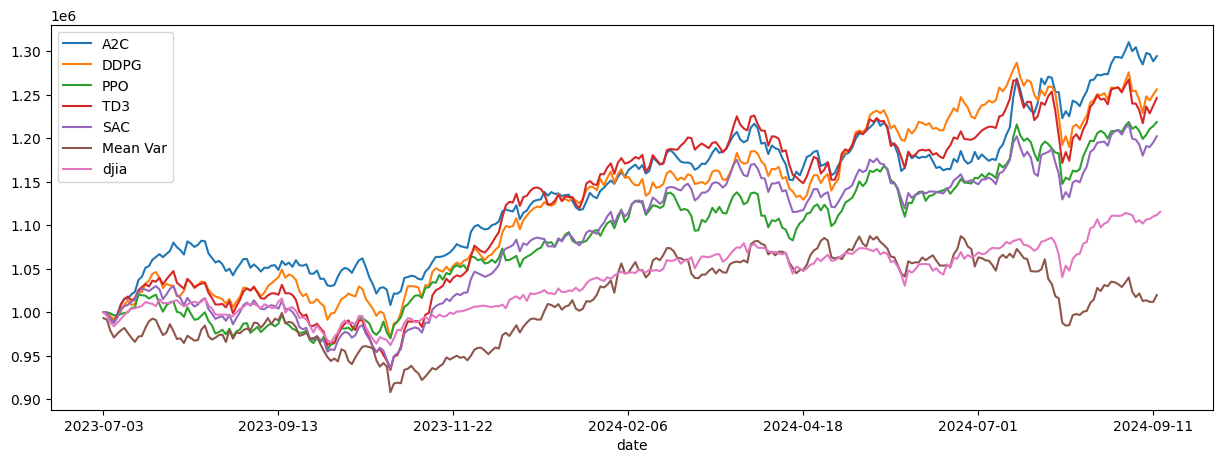

In [123]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()
